In [1]:
import numpy as np
import matplotlib.pyplot as plt


import scipy as sp
import scipy.linalg
import scipy.optimize

# import scipy.special

from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [2]:
class Jackknife:
    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.var_est += ( self.jack_avg[i] - self.est )**2
        self.var_est /= self.nbins
        self.var_est *= self.nbins -1

    def __init__( self, nbins, binsize, binned ):
        self.binsize = binsize
        self.nbins = nbins
        self.N = self.binsize * self.nbins
        self.binned = binned
        self.jack_avg = []
        self.est = 0
        self.var_est = 0
        
        for i in range( 0, self.nbins ):
            resmpld = np.delete(binned, i, 0)
            self.jack_avg.append( np.mean(resmpld, 0) )
            
        self.do_it()

    def mean( self ):
        return self.est

    def var( self ):
        return self.var_est

    def err( self ):
        return np.sqrt(self.var_est)
    
def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

def format_print_w_exact(exact, cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'+': '+'{num:.{width}f}'.format(num=(exact-cen)/err, width=i+1)+' sigma'

In [3]:
def theta(z, Tau, n=0, nmax=1e5, tol=1.0e-15):
    
    if n==0:
        r = np.pi*1.0j/Tau
        s = np.exp( -r*z**2 )

        s_old = s
        for ell in np.arange(1,nmax):
            s += np.exp( -r*(ell+z)**2 )
            s += np.exp( -r*(-ell+z)**2 )

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = 1.0 / np.sqrt(-1.0j*Tau)
        return coeff * s

    else:

        r = np.pi*1.0j/Tau
        arr = np.full(n+1, 0)
        arr[n]=1
        Hn = np.polynomial.hermite.Hermite( arr )

        coeff = Hn( np.sqrt(r)*z )
        exp = np.exp( -r*z**2 )
        s = coeff * exp

        s_old = s
        for ell in np.arange(1,nmax):
            coeff = Hn( np.sqrt(r)*(ell+z) )
            exp = np.exp( -r*(ell+z)**2 )
            s += coeff * exp

            coeff = Hn( np.sqrt(r)*(-ell+z) )
            exp = np.exp( -r*(-ell+z)**2 )
            s += coeff * exp

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = (-1)**n * r**(n/2) / np.sqrt(-1.0j*Tau)

        return coeff * s

In [4]:
def th1(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau+0.5, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s


def th2(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    return -coeff * s

def th3(z, n=0):
    return theta(z, tau, n)

def th4(z, n=0):
    return theta(z+0.5, tau, n)

In [5]:
def Dth1(z):
    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th1(z)
    s -= 0.5*coeff * th3(z+0.5*tau+0.5, 1)
    s -= 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 2)
    return s

def Dth2(z):
    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th2(z)
    s += 0.5*coeff * th3(z+0.5*tau, 1)
    s += 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 2)
    return s

def Dth3(z):
    return 1.0/(4.0*np.pi*1.0j) * th3(z, 2)

def Dth4(z):
    return 1.0/(4.0*np.pi*1.0j) * th4(z, 2)

In [6]:
def dDth1(z):
    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th1(z, 1)
    s -= 0.5*np.pi*1.0j*coeff * th3(z+0.5*tau+0.5, 1)
    s -= 0.5*coeff * th3(z+0.5*tau+0.5, 2)
    s -= np.pi*1.0j/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 2)
    s -= 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 3)
    return s

def dDth2(z):
    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th2(z, 1)
    s += 0.5*np.pi*1.0j*coeff * th3(z+0.5*tau, 1)
    s += 0.5*coeff * th3(z+0.5*tau, 2)
    s += np.pi*1.0j/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 2)
    s += 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 3)
    return s

def dDth3(z):
    return 1.0/(4.0*np.pi*1.0j) * th3(z, 3)

def dDth4(z):
    return 1.0/(4.0*np.pi*1.0j) * th4(z, 3)

In [7]:
def P(z):
    res = 0.0
    
    tmp = np.pi * th20*th30*th4(z)/th1(z)
    res += tmp**2
    
    tmp = th20**4 + th30**4
    tmp *= np.pi**2/3.0
    res -= tmp
    
    return res

def dP(z):
    coeff = (np.pi * th20*th30)**2
    
    f1 = th4(z) * th4(z,1) / th1(z)**2
    f2 = th4(z)**2 * th1(z,1) / th1(z)**3

    res = 2.0 * coeff * (f1-f2)
    
    return res

def ddP(z):    
    coeff = (np.pi * th20*th30)**2
    
    f1 = ( th4(z,1)**2 + th4(z) * th4(z,2) ) / th1(z)**2
    f2 = th4(z) * th4(z,1) * th1(z,1) / th1(z)**3
    f3 = th4(z)**2 * th1(z,2) / th1(z)**3
    f4 = th4(z)**2 * th1(z,1)**2 / th1(z)**4

    res = 2.0 * coeff * (f1 - 4.0*f2 -f3 + 3.0*f4 )
    
    return res

In [8]:
def P2(z):
    return th1p0/th20 * th2(z)/th1(z)

def P3(z):
    return th1p0/th30 * th3(z)/th1(z)

def P4(z):
    return th1p0/th40 * th4(z)/th1(z)

# def P2Alt(z):
#     return np.sqrt( P(z)-e1 )
# def P3Alt(z):
#     return np.sqrt( P(z)-e2 )
# def P4Alt(z):
#     return np.sqrt( P(z)-e3 )

In [9]:
def dP2(z):
    return th1p0/th20 * ( th2(z,1)/th1(z) - th2(z)*th1(z,1)/th1(z)**2 )

def ddP2(z):
    return th1p0/th20 * ( th2(z,2)/th1(z) - 2.0*th2(z,1)*th1(z,1)/th1(z)**2 - th2(z)*th1(z,2)/th1(z)**2 + 2.0*th2(z)*th1(z,1)**2/th1(z)**3 )

In [10]:
def dP3(z):
    return th1p0/th30 * ( th3(z,1)/th1(z) - th3(z)*th1(z,1)/th1(z)**2 )

def ddP3(z):
    return th1p0/th30 * ( th3(z,2)/th1(z) - 2.0*th3(z,1)*th1(z,1)/th1(z)**2 - th3(z)*th1(z,2)/th1(z)**2 + 2.0*th3(z)*th1(z,1)**2/th1(z)**3 )

In [11]:
def dP4(z):
    return th1p0/th40 * ( th4(z,1)/th1(z) - th4(z)*th1(z,1)/th1(z)**2 )

def ddP4(z):
    return th1p0/th40 * ( th4(z,2)/th1(z) - 2.0*th4(z,1)*th1(z,1)/th1(z)**2 - th4(z)*th1(z,2)/th1(z)**2 + 2.0*th4(z)*th1(z,1)**2/th1(z)**3 )

In [12]:
def dedekind( t ):
    return np.exp( np.pi*1.0j*t/12.0 ) * theta(0.5*(t+1.0), 3.0*t)

In [13]:
def ZM( nu ):
    eta = dedekind( tau )
    coeff = 1.0/(2.0* np.abs(eta) )

    if nu == 2: res = coeff * np.abs(th20)
    elif nu == 3: res = coeff * np.abs(th30)
    elif nu == 4: res = coeff * np.abs(th40)
    elif nu == 1: res = 0.0
    
    return res

In [14]:
def ZI( nu ):
    res = 0.0
    
    for nup in range(1, 5):
        if nup == nu: continue
        else: res += ZM(nup)

    res -= ZM(nu)
    res *= 0.5
    
    return res

In [15]:
def ZMss_nu(z, nu):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    denom = np.abs( th1(z) )**(1/4)
    
    if nu==1: numer=np.abs( th1(0.5*z) )
    elif nu==2: numer=np.abs( th2(0.5*z) )
    elif nu==3: numer=np.abs( th3(0.5*z) )
    elif nu==4: numer=np.abs( th4(0.5*z) )
    else: assert(false)
    
    return factor * numer/denom

In [16]:
def ZMtot():
    res = 0.0
    for nup in range(1, 5):
        res += ZM(nup)
    return res

In [17]:
def ss_corr_analytic(z):
    res = 0.0
    for nu in range(1,5):
        res += ZMss_nu( z,nu )

    res /= ZMtot()
    
    return res

In [18]:
def epseps_corr_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * np.abs( P2(z) )**2
    res += ZM( 3 ) * np.abs( P3(z) )**2
    res += ZM( 4 ) * np.abs( P4(z) )**2

    res /= ZMtot()
    
    return res

In [19]:
def T_1pt_analytic():
    res = 0.0
    
    res += ZM( 2 ) * e1
    res += ZM( 3 ) * e2
    res += ZM( 4 ) * e3

    res /= ZMtot()
    res *= -0.25
    
    return res

In [20]:
def TTconn2(z):
    return -0.25 * ( dP2(z)**2 - ddP2(z)*P2(z) )

def TTconn3(z):
    return -0.25 * ( dP3(z)**2 - ddP3(z)*P3(z) )

def TTconn4(z):
    return -0.25 * ( dP4(z)**2 - ddP4(z)*P4(z) )

def TT_conn_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * TTconn2(z)
    res += ZM( 3 ) * TTconn3(z)
    res += ZM( 4 ) * TTconn4(z)

    res /= ZMtot()
    
    return res

In [21]:
def zeta(z):
    return th1(z,1)/th1(z) + 2.0*eta1*z

In [22]:
def dZMss_nu1(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )

    th1z = th1(z)
    th1H = th1(0.5*z)
    
    dth1z = th1(z, 1)
    dth1H = th1(0.5*z, 1)

    tmp1 = 0.25 * dth1H * np.conj(th1H) / ( np.abs(th1H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th1H ) * dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return factor * (tmp1+tmp2)

def dZMss_nu2(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )

    th1z = th1(z)
    th2H = th2(0.5*z)
    
    dth1z = th1(z, 1)
    dth2H = th2(0.5*z, 1)

    tmp1 = 0.25 * dth2H * np.conj(th2H) / ( np.abs(th2H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th2H ) * dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return factor * (tmp1+tmp2)

def dZMss_nu3(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )

    th1z = th1(z)
    th3H = th3(0.5*z)
    
    dth1z = th1(z, 1)
    dth3H = th3(0.5*z, 1)

    tmp1 = 0.25 * dth3H * np.conj(th3H) / ( np.abs(th3H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th3H ) * dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return factor * (tmp1+tmp2)

def dZMss_nu4(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )

    th1z = th1(z)
    th4H = th4(0.5*z)
    
    dth1z = th1(z, 1)
    dth4H = th4(0.5*z, 1)

    tmp1 = 0.25 * dth4H * np.conj(th4H) / ( np.abs(th4H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th4H ) * dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return factor * (tmp1+tmp2)

In [23]:
def dss_corr_analytic(z):
    res = 0.0

    res += dZMss_nu1( z )
    res += dZMss_nu2( z )
    res += dZMss_nu3( z )
    res += dZMss_nu4( z )

    res /= ZMtot()
    
    return res

In [24]:
def Ddedekind( t ):
    res = 0.0
    res += np.pi*1.0j/12.0 * dedekind(t)
    res += np.exp( np.pi*1.0j*t/12.0 ) * 0.5 * theta(0.5*(t+1.0), 3.0*t, 1)
    res += np.exp( np.pi*1.0j*t/12.0 ) * 3.0 / (4.0*np.pi*1.0j) * theta(0.5*(t+1.0), 3.0*t, 2)
    return res

In [25]:
def DZM2():
    eta = dedekind( tau )
    Deta = Ddedekind( tau )
    Dth20 = Dth2(0)
    
    tmp1 = -0.25 * Deta * np.conj(eta) / np.abs(eta)**3 * np.abs( th20 )
    tmp2 = 0.25 * Dth20 * np.conj(th20) / (np.abs(eta)*np.abs(th20))
    
    return tmp1 + tmp2

def DZM3():
    eta = dedekind( tau )
    Deta = Ddedekind( tau )
    Dth30 = Dth3(0)
    
    tmp1 = -0.25 * Deta * np.conj(eta) / np.abs(eta)**3 * np.abs( th30 )
    tmp2 = 0.25 * Dth30 * np.conj(th30) / (np.abs(eta)*np.abs(th30))
    
    return tmp1 + tmp2

def DZM4():
    eta = dedekind( tau )
    Deta = Ddedekind( tau )
    Dth40 = Dth4(0)
    
    tmp1 = -0.25 * Deta * np.conj(eta) / np.abs(eta)**3 * np.abs( th40 )
    tmp2 = 0.25 * Dth40 * np.conj(th40) / (np.abs(eta)*np.abs(th40))
    
    return tmp1 + tmp2

# 2.0*np.pi*1.0j * DZM4()
# -0.25*e3 * ZM(4)

In [26]:
def DZMtot():
    return DZM2() + DZM3() + DZM4()

In [27]:
def DZMss_nu1(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    Dlnfactor = -1.0/24.0 / th1p0**2 * dDth1(0) * np.conj(th1p0)

    th1z = th1(z)
    th1H = th1(0.5*z)
    
    Dth1z = Dth1(z)
    Dth1H = Dth1(0.5*z)

    tmp0 = Dlnfactor * ZMss_nu(z, 1)
    tmp1 = 0.5 * Dth1H * np.conj(th1H) / ( np.abs(th1H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th1H ) * Dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return tmp0 + factor * (tmp1+tmp2)

def DZMss_nu2(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    Dlnfactor = -1.0/24.0 / th1p0**2 * dDth1(0) * np.conj(th1p0)

    th1z = th1(z)
    th2H = th2(0.5*z)
    
    Dth1z = Dth1(z)
    Dth2H = Dth2(0.5*z)

    tmp0 = Dlnfactor * ZMss_nu(z, 2)
    tmp1 = 0.5 * Dth2H * np.conj(th2H) / ( np.abs(th2H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th2H ) * Dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return tmp0 + factor * (tmp1+tmp2)

def DZMss_nu3(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    Dlnfactor = -1.0/24.0 / th1p0**2 * dDth1(0) * np.conj(th1p0)

    th1z = th1(z)
    th3H = th3(0.5*z)
    
    Dth1z = Dth1(z)
    Dth3H = Dth3(0.5*z)

    tmp0 = Dlnfactor * ZMss_nu(z, 3)
    tmp1 = 0.5 * Dth3H * np.conj(th3H) / ( np.abs(th3H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th3H ) * Dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return tmp0 + factor * (tmp1+tmp2)

def DZMss_nu4(z):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    Dlnfactor = -1.0/24.0 / th1p0**2 * dDth1(0) * np.conj(th1p0)

    th1z = th1(z)
    th4H = th4(0.5*z)
    
    Dth1z = Dth1(z)
    Dth4H = Dth4(0.5*z)

    tmp0 = Dlnfactor * ZMss_nu(z, 4)
    tmp1 = 0.5 * Dth4H * np.conj(th4H) / ( np.abs(th4H)*np.abs(th1z)**0.25 )
    tmp2 = -0.125 * np.abs( th4H ) * Dth1z * np.conj(th1z) / np.abs(th1z)**2.25
    
    return tmp0 + factor * (tmp1+tmp2)

In [28]:
def Dss_corr_analytic(z):
    res = 0.0

    res += DZMss_nu1( z )
    res += DZMss_nu2( z )
    res += DZMss_nu3( z )
    res += DZMss_nu4( z )
    res /= ZMtot()

    ztot = ZMtot()
    Dztot = DZMtot()
    
    res -= Dztot/ztot * ss_corr_analytic( z )
    
    return res

In [29]:
def Tss_analytic(w0, w1, w2):

    ss = ss_corr_analytic(w1-w2)
    dss = dss_corr_analytic(w1-w2)

    tmp1 = 1.0/16.0 * ( P(w1-w0) + 2.0*eta1 ) * ss
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dss

    tmp3 = 1.0/16.0 * ( P(w2-w0) + 2.0*eta1 ) * ss
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dss

    tmp5 = 2.0*np.pi*1.0j * Dss_corr_analytic(w1-w2)

    tmp6 = T_1pt_analytic() * ss
    
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6

In [30]:
# Lx = 9
# Ly = 12
mult = 6 # 12
Lx = 3*mult
Ly = 3*mult

tautil = 1.2*np.exp( 1.0j* 4.0/9.0 * np.pi)
# tautil = 1.0*np.exp( 1.0j* 3.0/9.0 * np.pi)
# tautil = 1.0*np.exp( 1.0j* 4.5/9.0 * np.pi)
# tautil = 1.0*np.exp( 1.0j* 5.0/9.0 * np.pi)
# tautil = 0.5*( 3.0+np.sqrt(3.0)*1.0j )
# tautil = 2.0+1.0j

tautil1 = np.real(tautil)
tautil2 = np.imag(tautil)

tau = Ly/Lx * tautil

# Nbintot = 535 # int(1e3)
Nbintot = 21 # 1066 # int(1e3) # 361 # int(1e3)
binsize = int(1e4)
# Nbintot = 4
# binsize = 1e2

nskip = 6 # int(1e2)
Nbin = Nbintot-nskip

np.abs(tautil)

1.1999999999999997

In [31]:
th1p0 = th1(0, 1)
th20 = th2(0)
th30 = th3(0)
th40 = th4(0)

e1 = 1.0/3.0 * (np.pi)**2 * (th30**4 + th40**4)
e2 = 1.0/3.0 * (np.pi)**2 * (th20**4 - th40**4)
e3 = -1.0/3.0 * (np.pi)**2 * (th20**4 + th30**4)

eta1 = -1.0/6.0 * th1(0, n=3)/th1(0, n=1)

In [32]:
e1, e2, e3

((6.60402118937777+0.09094382058645076j),
 (-1.7746896760022504+1.1324202785432997j),
 (-4.829331513375519-1.2233640991297505j))

In [33]:
ZM( 2 ), ZM( 3 ), ZM( 4 )

(0.538770773415979, 0.7080806064533179, 0.6553197853952919)

In [34]:
# description="Lx"+str(Lx)+"Ly"+str(Ly)+"nu1"
description="Lx"+str(Lx)+"Ly"+str(Ly)+"nu1tautil"+'{:.6f}'.format(tautil1)+"_"+'{:.6f}'.format(tautil2)
# directory1="mult"+str(mult)+"/data_"+description+"/"
directory1="data_"+description+"/"

In [35]:
T_1pt_analytic()

(0.11346589687966104-0.006459462237312887j)

In [36]:
ell_tri = np.loadtxt(description+"ell.dat", delimiter=",")
kappa = np.loadtxt(description+"kappa.dat", delimiter=",")
ellstar = np.loadtxt(description+"ellstar.dat", delimiter=",")
e = np.loadtxt(description+"e.dat", delimiter=",")
cosH = np.loadtxt(description+"cosH.dat", delimiter=",")
beta = np.loadtxt(description+"beta.dat", delimiter=",")

In [37]:
0.5 * np.log(2.0 + np.sqrt(3.0))

0.6584789484624083

In [38]:
beta

array([0.10753454, 0.46929201, 0.27970807])

In [39]:
tanhBeta = np.tanh(beta)
coshBeta = np.cosh(beta)

In [40]:
# DBetaDmu=-0.5*tanhBeta*coshBeta**2
# DBetaDKappa = np.sinh(beta)*np.cosh(beta)/kappa

In [41]:
mat0 = np.array([
    [kappa[0], kappa[1], kappa[2]],
    [kappa[0]*e[0][0], kappa[1]*e[1][0], kappa[2]*e[2][0]],
    [kappa[0]*e[0][1], kappa[1]*e[1][1], kappa[2]*e[2][1]]
])

c=0.0

tilde_ell0 = np.linalg.inv(mat0)@np.array([c, 1.0, 0.0])
tilde_ell1 = np.linalg.inv(mat0)@np.array([c, 0.0, 1.0])

tilde_ell_tmp = np.array([tilde_ell0, tilde_ell1]).T

dualshift = (tilde_ell_tmp[2] - tilde_ell_tmp[0] - tilde_ell_tmp[1])/2.0

tmp_tilde = tilde_ell_tmp[2] + 2.0 * dualshift
tmp_tri = ell_tri[1] - ell_tri[0]

assert np.abs( tmp_tilde[1] / tmp_tilde[0] - tmp_tri[1] / tmp_tri[0] ) < 1.0e-14
relative = tmp_tilde[0] / tmp_tri[0]

tilde_ell = tilde_ell_tmp / relative

In [42]:
alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])
alphaM = [alA, alB, alC]

def ArcTan( x, y ):
    tmp = np.arctan( y/x )
    if x<0:
        tmp += np.pi
    return tmp

tildeAlA = ArcTan( tilde_ell[0][0], tilde_ell[0][1] )
tildeAlB = ArcTan( tilde_ell[1][0], tilde_ell[1][1] )
tildeAlC = ArcTan( tilde_ell[2][0], tilde_ell[2][1] )

tildealphaM = [tildeAlA, tildeAlB, tildeAlC]

In [43]:
# aaa = ell_tri[0]
# bbb = ell_tri[1]

# np.inner(aaa, bbb) / ( np.linalg.norm(aaa) * np.linalg.norm(bbb) )

In [44]:
# aaa = tilde_ell[0]
# bbb = tilde_ell[1]

# np.inner(aaa, bbb) / ( np.linalg.norm(aaa) * np.linalg.norm(bbb) )

In [45]:
# ell_tri[0] + ell_tri[1] + ell_tri[2]

In [46]:
# ellstar[0] + ellstar[1] - ellstar[2]

In [47]:
# tilde_ell[0] - tilde_ell[1] + tilde_ell[2]

In [48]:
Ell=np.sqrt(np.array([
    ell_tri[0,0]**2 + ell_tri[0,1]**2,
    ell_tri[1,0]**2 + ell_tri[1,1]**2,
    ell_tri[2,0]**2 + ell_tri[2,1]**2
]))

Ellx = tilde_ell[1]-tilde_ell[0]+tilde_ell[2]-tilde_ell[0]
Elly = tilde_ell[2]-tilde_ell[0]+tilde_ell[2]-tilde_ell[1]

AEllx = np.sqrt( Ellx[0]*Ellx[0] + Ellx[1]*Ellx[1] )
AElly = np.sqrt( Elly[0]*Elly[0] + Elly[1]*Elly[1] )

In [49]:
# ellstar

In [50]:
# Ellx

In [51]:
# Elly/AEllx

In [52]:
# tau

In [53]:
alat = 1.0 / Lx

In [54]:
s = 0.5*( Ell[0]+Ell[1]+Ell[2] )
# Area_lat = np.sqrt( s*(s-Ell[0])*(s-Ell[1])*(s-Ell[2]) )

alat = 3.0 / AEllx / Lx
r = np.sqrt( s * alat )
# r = np.sqrt( alat )

Ntri = int(Lx*Ly * 2/3)

# optimalFit = [-0.146428, 0.900587]

alA = np.sign(e[0][1])*np.arccos(e[0][0])
alB = np.sign(e[1][1])*np.arccos(e[1][0])
alC = np.sign(e[2][1])*np.arccos(e[2][0])

alphaM = [alA, alB, alC]
Lxeff = int(Lx*2/3)

In [55]:
# s = 0.5*( Ell[0]+Ell[1]+Ell[2] )
# Area_lat = np.sqrt( s*(s-Ell[0])*(s-Ell[1])*(s-Ell[2]) )

# alat = 3.0 / AEllx / Lx
# r = np.sqrt( s * alat )

# Ntri = int(Lx*Ly * 2/3)

In [56]:
# kappa = 2.0/3.0
# cos = np.cos( np.pi/6.0 )
# B = cos / ( 1.0 - kappa**2 * cos**2 )
# alat = 1.0/Lx

# tanhbeta = kappa*cos

# alat = 1.0/Lx
# r = np.sqrt(3.0/2.0 * np.sqrt(3.0) * alat) # 

In [57]:
# eps = 1.0e-5
# zz = 0.2+0.3j
# ( P2( zz+eps )-P2( zz-eps ) ) / (2.0*eps)
# dP2(zz)

# generate lattice

In [58]:
Ntot = Lx*Ly

In [59]:
dualshift = (tilde_ell[2] - tilde_ell[0] - tilde_ell[1])/2.0

tmp_tilde = tilde_ell[2] + 2.0 * dualshift
tmp_tri = ell_tri[1] - ell_tri[0]

assert np.abs( tmp_tilde[1] / tmp_tilde[0] - tmp_tri[1] / tmp_tri[0] ) < 1.0e-14
relative = tmp_tilde[0] / tmp_tri[0]

In [60]:
pts_ = []
ppts_ = []

for yc in range(Ly):
    if yc==0:
        pts_.append( [ 0, 0, 0, 0, 0 ] )
    else:
        prev = pts_[-Lx]
        if yc%3!=1:
            pts_.append( [0, yc, 
                          prev[2]-0.5*ell_tri[0][0]*relative-0.5*tilde_ell[0][0], 
                          prev[3]-0.5*ell_tri[0][1]*relative-0.5*tilde_ell[0][1], 
                          (0-yc+Ntot)%3] )
#             pts_.append( [0, yc, 
#                           prev[2]-tilde_ell[0][0], 
#                           prev[3]-tilde_ell[0][1], 
#                           (0-yc+Ntot)%3] )

        else:
            pts_.append( [0, yc, 
                          prev[2]+tilde_ell[2][0], 
                          prev[3]+tilde_ell[2][1], 
                          2] )
    
    if pts_[-1][4]!=1:
        ppts_.append( pts_[-1] )
            
    for xp in range(Lx-1):
        prev = pts_[-1]
        c = (xp-yc + Ntot)%3
        if c==1:
            pts_.append( [xp+1, yc, 
                          prev[2]-0.5*ell_tri[2][0]*relative+0.5*tilde_ell[2][0], 
                          prev[3]-0.5*ell_tri[2][1]*relative+0.5*tilde_ell[2][1], 
                          2] )
#             pts_.append( [xp+1, yc, 
#                           prev[2]+tilde_ell[2][0], 
#                           prev[3]+tilde_ell[2][1], 
#                           2] )

        elif c==2:
            pts_.append( [xp+1, yc, 
                          prev[2]-tilde_ell[0][0], 
                          prev[3]-tilde_ell[0][1], 
                          0 ] )
        else:
            pts_.append( [xp+1, yc, 
                          prev[2]+0.5*ell_tri[1][0]*relative+0.5*tilde_ell[1][0], 
                          prev[3]+0.5*ell_tri[1][1]*relative+0.5*tilde_ell[1][1], 
                          1 ] )
#             pts_.append( [xp+1, yc, 
#                           prev[2]+tilde_ell[1][0], 
#                           prev[3]+tilde_ell[1][1], 
#                           1 ] )
        
        if pts_[-1][4]!=1:
            ppts_.append( pts_[-1] )

pts = np.array( pts_ )
ppts = np.array( ppts_ )

pts.T[2] *= alat
pts.T[3] *= alat

ppts.T[2] *= alat
ppts.T[3] *= alat

In [61]:
type0_=[]
type1_=[]
type2_=[]
for pt in pts:
    if pt[-1]==0: type0_.append( pt )
    elif pt[-1]==1: type1_.append( pt )
    elif pt[-1]==2: type2_.append( pt )


type0 = np.array(type0_)
type1 = np.array(type1_)
type2 = np.array(type2_)

(-0.01, 0.1)

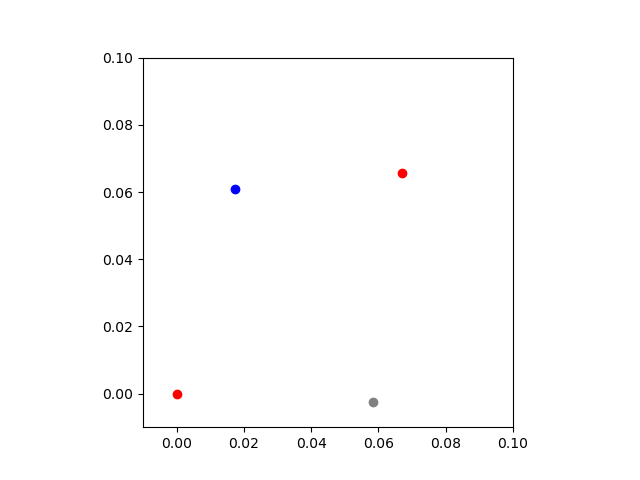

In [62]:
plt.close()
plt.plot( type0.T[2], type0.T[3], ls="none", marker="o", color='red' )
plt.plot( type1.T[2], type1.T[3], ls="none", marker="o", color='gray' )
plt.plot( type2.T[2], type2.T[3], ls="none", marker="o", color='blue' )
plt.gca().set_aspect('equal')
plt.xlim(-0.01, 0.1)
plt.ylim(-0.01, 0.1)

In [63]:
def getSiteXY():
    # type2Shifted = np.array( [type2.T[2], type2.T[3] ] ).T + Delta*alat
    res_ = []
    for i in range(type0.shape[0]):
        res_.append( [type0[i][2], type0[i][3]] )
    res = np.array(res_)
    return res

In [64]:
def getFaceXY():
    # type2Shifted = np.array( [type2.T[2], type2.T[3] ] ).T + Delta*alat
    res_ = []
    for i in range(type0.shape[0]):
        if type0[i][2]<type2[i][2]:
            res_.append( [type0[i][2], type0[i][3]] )
            res_.append( [type2[i][2], type2[i][3]] )
        else:
            res_.append( [type2[i][2], type2[i][3]] )
            res_.append( [type0[i][2], type0[i][3]] )
    res = np.array(res_)
    return res

In [65]:
# def getSiteXY():
#     res_=[]
#     for y in range(Ly):
#         for x in range(Lx):
#             res_.append([x + y*tautil1, y*tautil2])
#     res = alat*np.array(res_)    
#     return res

In [66]:
font = {'size'   : 12}
plt.rc('font', **font)

colors={
    2:'#006BA4',
    3:'#FF800E',
    4:'#ABABAB',
    "A":'#FFBC79',
    "B":'#5F9ED1',
    "C":'#C85200',
    6:'#898989',
    7:'#A2C8EC',
    8:'#595959',
    9:'#CFCFCF'
}

markers={
    2:"o", 
    3:"d", 
    4:"v", 
    "A":"x", 
    "B":"<", 
    "C":"^", 
}

# $\sigma\sigma$

In [67]:
Nbintot

21

In [68]:
Lxeff=int(Lx/3)
Lxeff

6

In [69]:
XY = getSiteXY()

In [70]:
ss_corr1 = np.array([np.loadtxt(directory1+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])
jk1 = Jackknife( Nbin, binsize, ss_corr1[nskip:] )

In [71]:
sscorr_analytic = np.array([ [elem[0], elem[1], 
                              ss_corr_analytic(elem[0]+1.0j*elem[1]) ] for elem in XY] )

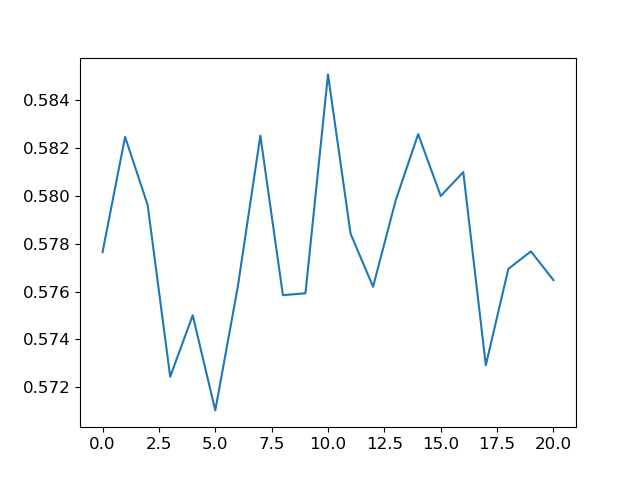

In [72]:
plt.clf()
plt.plot(ss_corr1[:,int(Lxeff/2),int(Lxeff/2)])
plt.show()

In [73]:
# y=np.mean(np.split(ss_corr1[:,int(Lx/2),int(Lx/2)], 5), axis=1)
# x=np.arange(y.shape[0])
# plt.clf()
# plt.plot( x, y )
# plt.show()

In [74]:
# plt.clf()
# plt.plot(ss_corr1[:,int(Lx/2),int(Lx/2)])
# plt.show()

In [75]:
shape = jk1.mean().shape
jkm = jk1.mean()
jke = jk1.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
ss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

In [76]:
# xx = np.full( (Lx,Ly), np.arange(Lx) ).flatten()
# yy = np.full( (Ly,Lx), np.arange(Ly) ).T.flatten()

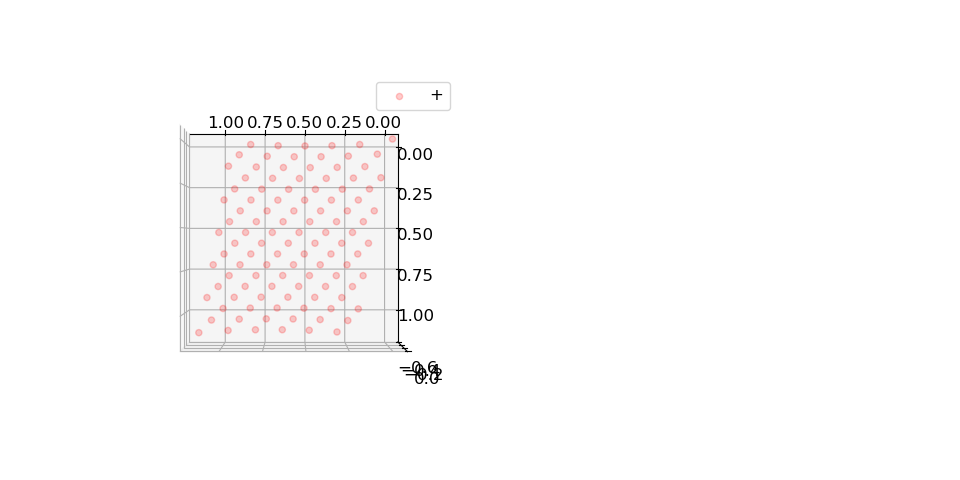

In [77]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1],
           np.log( ss1.T[2]), 
           c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

plt.show()

# #################

# fig.tight_layout()
# # plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

In [78]:
t = 4

yt = ss1[t*Lxeff:(t+1)*Lxeff]
# fac = u**2
# fac = 3.0
fac = 3.17
# fac = 0.29

In [79]:
xx = sscorr_analytic.T[0][t*Lxeff:(t+1)*Lxeff]
yy = sscorr_analytic.T[2][t*Lxeff:(t+1)*Lxeff]

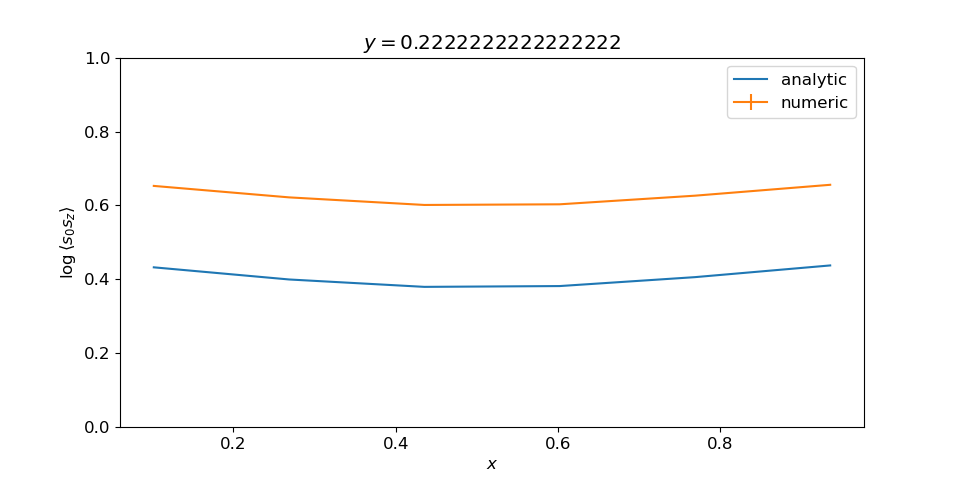

In [80]:
# plt.close()
plt.clf()

# x = XY.T[0][t*Lxeff:(t+1)*Lxeff]
# y = np.array( [ss_corr_analytic( xx + tau*t/Ly ) for xx in XY.T[0][0:Lxeff]] )

plt.plot( xx, np.log(yy), label="analytic" )

plt.errorbar( xx, np.log( fac * yt.T[2]), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

plt.legend()
plt.ylim( 0.0, 1.0 )

# plt.xscale("log")

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")
# plt.savefig('./ss_yslice_'+description+'.pdf',bbox_inches='tight')
plt.show()

In [81]:
# # plt.close()
# plt.clf()

# x = np.arange(0, Ly)/Ly
# y = np.array( [ss_corr_analytic( t/Lx + tau*yy ) for yy in x] )

# plt.plot( x, np.log(y), label="analytic" )
# plt.errorbar( xt.T[1]/Ly, np.log(fac * xt.T[2]), np.abs(xt.T[3]/xt.T[2]), label="numeric" )

# plt.legend()
# plt.ylim( 0.0, 1.0 )

# plt.title("$x="+str(t/Lx)+"$")
# plt.xlabel("$y$")
# plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")

# plt.savefig('./ss_xslice.pdf',bbox_inches='tight')
# plt.show()

# $\varepsilon$

In [82]:
# KA = np.array([np.loadtxt(directory1+"KA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KB = np.array([np.loadtxt(directory1+"KB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KC = np.array([np.loadtxt(directory1+"KC_"+str(i)+".dat") for i in range(1, Nbintot+1)])
eps_1pt1 = np.array([np.loadtxt(directory1+"eps_1pt_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [83]:
# Ks = np.array([ KA, KB, KC ]).transpose()
# # eps_1pt_ori = - np.sum( DBetaDmu*tanhBeta ) + np.sum( DBetaDmu*Ks, axis=1 ) + 1.0 - div_eps
# eps_1pt_ori = np.sum( DBetaDmu*tanhBeta ) - np.sum( DBetaDmu*Ks, axis=1 ) - 1.0 + div_eps

eps1 = 2.0*np.pi/r**2 * eps_1pt1

In [84]:
jk = Jackknife( Nbin, binsize, eps1[nskip:] )

In [85]:
eta = dedekind( tau )
sumTh = np.abs(th20) + np.abs(th30) + np.abs(th40)
eps_1pt_analytic = 2.0 * np.pi * np.abs(eta)**3 / sumTh

In [86]:
print( format_print( jk.mean(), jk.err() ) )
print( "exact", eps_1pt_analytic )

format_print_w_exact(-eps_1pt_analytic, jk.mean(), jk.err() )

-0.8966(95)
exact 0.8892771901751482


'-0.8966(95): 0.7760 sigma'

In [87]:
print( format_print( jk.mean(), jk.err() ) )
print( "exact", eps_1pt_analytic )

format_print_w_exact(-eps_1pt_analytic, jk.mean(), jk.err() )

-0.8966(95)
exact 0.8892771901751482


'-0.8966(95): 0.7760 sigma'

# $\varepsilon \varepsilon$

In [88]:
# KAKA = np.array([np.loadtxt(directory1+"KAKA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KAKB = np.array([np.loadtxt(directory1+"KAKB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KAKC = np.array([np.loadtxt(directory1+"KAKC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

# KBKA = np.array([np.loadtxt(directory1+"KBKA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KBKB = np.array([np.loadtxt(directory1+"KBKB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KBKC = np.array([np.loadtxt(directory1+"KBKC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

# KCKA = np.array([np.loadtxt(directory1+"KCKA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KCKB = np.array([np.loadtxt(directory1+"KCKB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KCKC = np.array([np.loadtxt(directory1+"KCKC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

epseps1 = np.array([np.loadtxt(directory1+"epseps_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [89]:
epseps1.shape

(21, 18, 12)

In [90]:
XY = getFaceXY()

In [91]:
epseps_analytic = np.array([ [elem[0], elem[1], 
                              eps_1pt_analytic**2 + epseps_corr_analytic(elem[0]+1.0j*elem[1]) ] for elem in XY] )

In [92]:
# epseps_ = []

# for step in np.arange( KKs[0][0].shape[0] ):
#     tmp=np.full(KKs[0][0].shape[1:], 0.0)
#     for iA in np.arange(3):
#         for iB in np.arange(3):
#             bracket = np.copy(KKs[iA][iB][step])
# #            bracket -= Ks[step][iA]*Ks[step][iB]
#             bracket += - Ks[step][iA]*tanhBeta[iB] - Ks[step][iB]*tanhBeta[iA] 
#             bracket += tanhBeta[iA]*tanhBeta[iB]
            
#             tmp+=DBetaDmu[iA]*DBetaDmu[iB]*bracket
#         # tmp+=2.0*DBetaDmu[iA]*(tanhBeta[iA]-Ks[step][iA])*(div_eps-1.0)
#         tmp+=2.0*DBetaDmu[iA]*(tanhBeta[iA]-Ks[step][iA])*(-1.0+div_eps)
#     # tmp+=(1.0-div_eps)**2
#     tmp+=(-div_eps+1.0)**2
#     epseps_.append(tmp)
# epseps = np.array( epseps_ )
# #        epseps_+=

In [93]:
epseps_rescaled = (2.0*np.pi)**2/r**4 * epseps1
jk = Jackknife( Nbin, binsize, epseps_rescaled[nskip:] )

In [94]:
shape

(18, 6)

In [95]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [XY.T[0][xx], XY.T[1][yy], 
                   jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
epseps1=np.array(np.split(tmp2, tmp2.shape[0]/4))

In [96]:
epseps1.shape

(216, 4)

In [97]:
XY.shape

(216, 2)

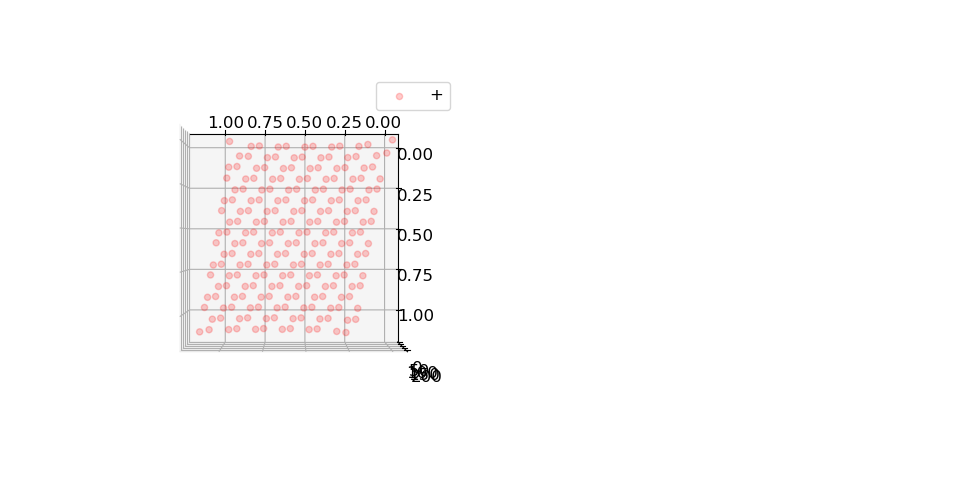

In [98]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], epseps1.T[2], c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

# ax.set_zlim(9.38, 9.4)

plt.show()

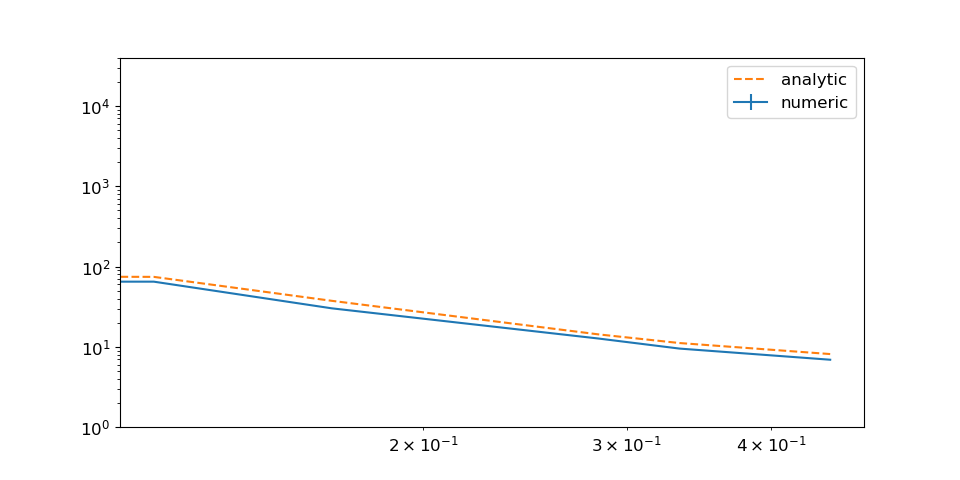

In [99]:
plt.close()
plt.clf()

plt.errorbar(
    epseps1.T[0][:int(Lxeff)],
    # epseps1.T[0][:int(Lxeff):2], 
    epseps1.T[2][:int(Lxeff)],
    epseps1.T[3][:int(Lxeff)],
#    epseps.T[2][:int(2*Lx/3)] / rel**16,
    label="numeric"
        )

plt.plot(
    epseps_analytic.T[0][:int(Lxeff)],
    epseps_analytic.T[2][:int(Lxeff)],
    label="analytic", 
    ls="dashed"
)

plt.xscale("log")
plt.yscale("log")

plt.ylim(1, 40000)

plt.legend()

plt.show()

# T (gen)

In [100]:
# KA = np.array([np.loadtxt(directory1+"KA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KB = np.array([np.loadtxt(directory1+"KB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# KC = np.array([np.loadtxt(directory1+"KC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [101]:
TA = np.array([np.loadtxt(directory1+"TA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TB = np.array([np.loadtxt(directory1+"TB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TC = np.array([np.loadtxt(directory1+"TC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [102]:
TA

array([ 4.27004361e-04,  3.03139835e-04,  1.42493253e-04, -1.09970431e-04,
        3.82855263e-04,  4.76169519e-04, -1.90288802e-06,  4.08317138e-04,
        5.30140448e-04,  1.13604990e-04,  2.28765369e-04,  1.47680408e-04,
        2.60609009e-04,  8.10238329e-05,  2.31402563e-04,  4.27673631e-04,
        2.00458425e-04,  4.23087021e-04,  4.09659050e-04,  4.50230608e-04,
        6.58238322e-04])

In [103]:
divs = np.array([0.23088000672608802, 0.2643308099111132, 0.24271706104663027])
# divs = np.array([0.25, 0.25, 0.25])
# numer = DBetaDKappa / ( alat * TildeEll )**0.25
# numer = DBetaDKappa / ( alat * Ellstar )**0.25
# denom = tanhBeta *DBetaDKappa + divs
# rat = numer/denom
# u = np.sqrt( np.mean(rat) )

In [104]:
TildeEll = np.array([ 
    np.linalg.norm(tilde_ell[0]),
    np.linalg.norm(tilde_ell[1]), 
    np.linalg.norm(tilde_ell[2]) 
])

In [105]:
# Ts = np.array([ KA, KB, KC ]).transpose()
Ts = np.array([ TA, TB, TC ]).transpose()

# hop_part = DBetaDKappa*( Ks - tanhBeta ) - divs
# eps_part = np.sum( DBetaDmu*tanhBeta ) - np.sum( DBetaDmu*Ks, axis=1 ) - 1.0 + div_eps
# subt = (hop_part.T - eps_part).T
scaled = Ts * 2.0*np.pi/r**2 / (TildeEll*alat)

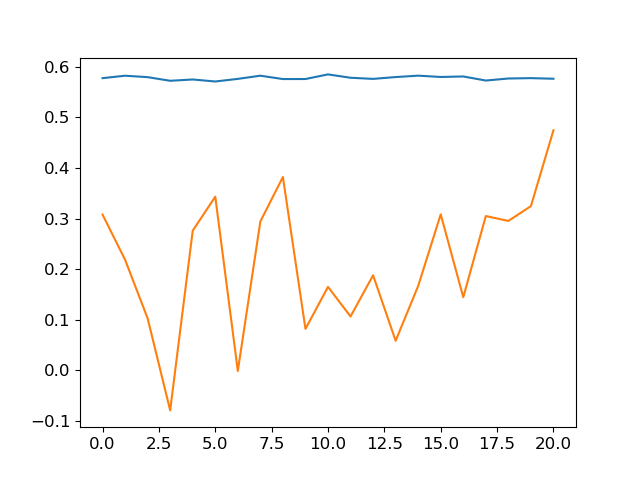

In [106]:
plt.close()
plt.plot(scaled.T[0])
plt.show()

In [107]:
jk = Jackknife( Nbin, binsize, scaled[nskip:] )

In [108]:
jk.mean()

array([ 0.21959842, -0.08707245, -0.10348584])

In [109]:
jk.err()

array([0.0343612 , 0.03100645, 0.03275109])

In [110]:
def mixing(x, theta_ ):
    return np.cos(theta_)*x[0] - np.sin(theta_)*x[1]

In [111]:
A = 2

angle = alphaM[A]+tildealphaM[A]

Tvev = T_1pt_analytic()
2.0 * mixing( [np.real(Tvev), np.imag(Tvev)], angle )

-0.13819639988748805

In [112]:
dM = (-divs - 1.0 + div_eps) * 2.0*np.pi/r**2 / (TildeEll*alat) / Lx**2

NameError: name 'div_eps' is not defined

In [ ]:
dM

In [113]:
mix_matrix = np.matrix([
    [np.cos(alphaM[0]+tildealphaM[0]), -np.sin(alphaM[0]+tildealphaM[0]), dM[0]],
    [np.cos(alphaM[1]+tildealphaM[1]), -np.sin(alphaM[1]+tildealphaM[1]), dM[1]],
    [np.cos(alphaM[2]+tildealphaM[2]), -np.sin(alphaM[2]+tildealphaM[2]), dM[2]]
])
TxxTxyOne = np.asarray( np.linalg.inv( mix_matrix ) @ scaled.T ).T

NameError: name 'dM' is not defined

In [114]:
jk = Jackknife( Nbin, binsize, TxxTxyOne[nskip:] )

NameError: name 'TxxTxyOne' is not defined

In [115]:
jk.mean()

array([ 0.21959842, -0.08707245, -0.10348584])

In [116]:
jk.err()

array([0.0343612 , 0.03100645, 0.03275109])

In [117]:
Tvev

(0.11346589687966104-0.006459462237312887j)

## TT (new)

In [118]:
TATA = np.array([np.loadtxt(directory1+"TATA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TATB = np.array([np.loadtxt(directory1+"TATB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TATC = np.array([np.loadtxt(directory1+"TATC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

TBTA = np.array([np.loadtxt(directory1+"TBTA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TBTB = np.array([np.loadtxt(directory1+"TBTB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TBTC = np.array([np.loadtxt(directory1+"TBTC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

TCTA = np.array([np.loadtxt(directory1+"TCTA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TCTB = np.array([np.loadtxt(directory1+"TCTB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TCTC = np.array([np.loadtxt(directory1+"TCTC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [119]:
TTs = np.array([
    [TATA, TATB, TATC],
    [TBTA, TBTB, TBTC],
    [TCTA, TCTB, TCTC]
])

# divs = np.array([0.23088000672608802, 0.2643308099111132, 0.24271706104663027])

In [120]:
TTs

array([[[[[ 4.58674412e-02,  3.17431289e-03,  1.48275718e-04,
            5.28775271e-05,  1.48275718e-04,  3.17431289e-03],
          [-4.71516265e-03,  5.18685266e-04,  2.68722642e-05,
           -3.62372588e-05,  2.00235739e-04, -4.32278403e-03],
          [-9.98585272e-04,  8.25397506e-05,  5.00734682e-05,
            7.62222569e-05, -5.32260836e-04,  2.20926994e-03],
          ...,
          [ 1.81854054e-04, -5.47699542e-05, -1.71120321e-04,
            3.93498240e-05,  7.30120172e-05, -2.28665802e-04],
          [ 2.20926994e-03, -5.32260836e-04,  7.62222569e-05,
            5.00734682e-05,  8.25397506e-05, -9.98585272e-04],
          [-4.32278403e-03,  2.00235739e-04, -3.62372588e-05,
            2.68722642e-05,  5.18685266e-04, -4.71516265e-03]],

         [[ 4.54301509e-02,  3.21414034e-03,  1.13381412e-04,
            9.25246908e-05,  1.13381412e-04,  3.21414034e-03],
          [-4.64345860e-03,  5.74176671e-04,  3.77212271e-05,
           -1.12519091e-05,  1.68790396e-04, -

In [121]:
iA = 0
iB = 1

In [122]:
scaled = TTs[iA][iB] * (2.0*np.pi)**2/r**4 / (TildeEll[iA]*alat) / (TildeEll[iB]*alat)

In [123]:
jk = Jackknife( Nbin, binsize, scaled[nskip:] )

In [124]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [XY.T[0][xx], XY.T[1][yy], 
                   jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
TT1=np.array(np.split(tmp2, tmp2.shape[0]/4))

In [125]:
XY = getSiteXY()

In [126]:
TT_analytic = np.array([ [elem[0], elem[1], 
                          T_1pt_analytic()**2 + TT_conn_analytic(elem[0]+1.0j*elem[1]) ] for elem in XY] )

In [127]:
# tmp = np.array([[ [xx, yy, TT_conn_analytic(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp2 = tmp.flatten()
# TTconn_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [128]:
# A = 2

# angle = alphaM[A]+tildealphaM[A]

# Tvev = T_1pt_analytic()
# 2.0 * mixing( [np.real(Tvev), np.imag(Tvev)], angle )

In [129]:
# TTc_analytic = np.array([ [elem[0], elem[1], 
#                            TT_conn_analytic(elem[0]+1.0j*elem[1]) ] for elem in XY] )

/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


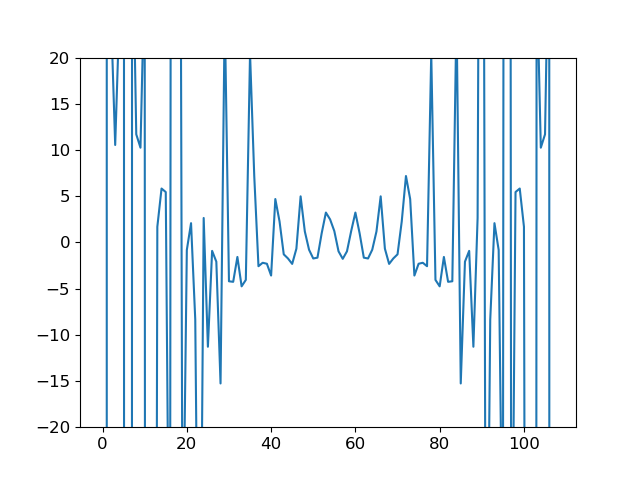

In [130]:
plt.clf()
plt.plot(TT_analytic.T[2])
plt.ylim(-20, 20)
plt.show()

In [131]:
angle = alphaM[iA]+tildealphaM[iA] + alphaM[iB]+tildealphaM[iB]
tmp = 2.0 * mixing( [np.real(TT_analytic.T[2]), np.imag(TT_analytic.T[2])], angle )
TMTN_analytic = np.array([XY.T[0], XY.T[1], tmp]).T

/tmp/ipykernel_8496/1573592239.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(TT1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_8496/1573592239.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-TT1.T[2]), c='b', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_8496/1573592239.py:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(TMTN_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_8496/1573592239.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-TMTN_analytic.T[2]), c='b', marker='o', label="+", alpha=0.2)


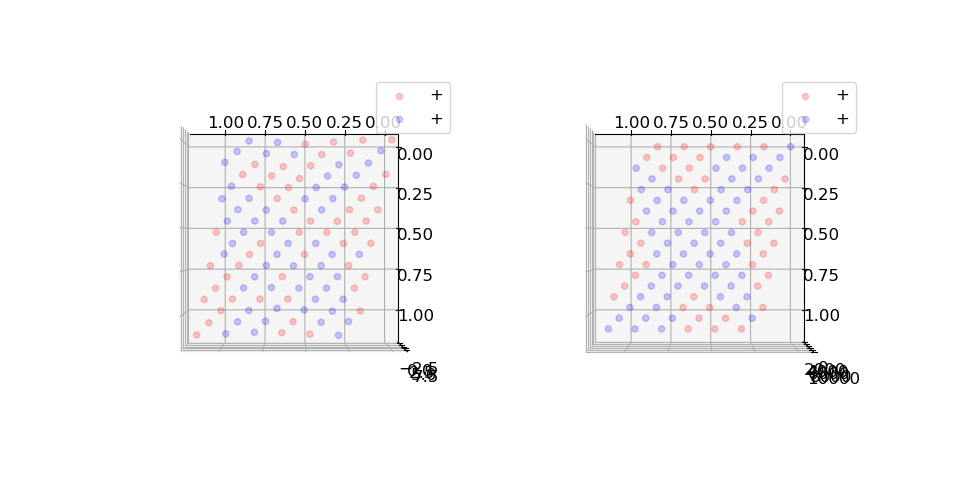

In [132]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(TT1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-TT1.T[2]), c='b', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(TMTN_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-TMTN_analytic.T[2]), c='b', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax.set_zlim(-2, 10000)
# ax.set_zlim(9.38, 9.4)

plt.show()

In [133]:
np.abs(TT1.T[2][:int(Lxeff)])

array([2.51256518e+03, 1.27273342e+03, 6.74727171e+01, 1.43284884e+00,
       2.76727291e+01, 3.35747663e+02])

In [134]:
TT1.T[3][:int(Lxeff)]

array([8.81731981, 6.09154646, 6.50396659, 5.48430231, 4.47538293,
       9.36176694])

/tmp/ipykernel_8496/3257293694.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim( 0.0, np.exp(20.0) )


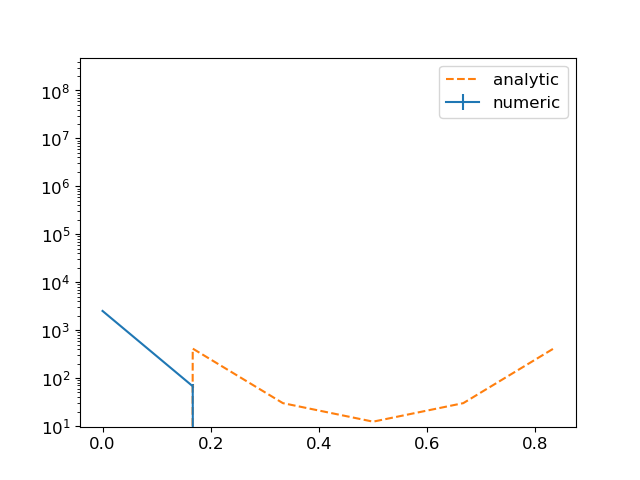

In [135]:
plt.close()
plt.clf()

plt.errorbar(
    TT1.T[0][:int(Lxeff):2],
    TT1.T[2][:int(Lxeff):2], 
    # np.abs(TT1.T[2][:int(Lxeff):2]),
    TT1.T[3][:int(Lxeff):2],
#    TT.T[2][:int(2*Lx/3)] / rel**16,
    label="numeric"
        )

plt.plot(
    TMTN_analytic.T[0][:int(Lxeff)],
    4.0*TMTN_analytic.T[2][:int(Lxeff)],
    label="analytic", 
    ls="dashed"
)

# plt.xscale("log")
plt.yscale("log")

plt.ylim( 0.0, np.exp(20.0) )
# plt.ylim(1, 400)

plt.legend()

plt.show()

In [136]:

Lx

18

In [137]:
# plt.close()
# fig = plt.figure(figsize=plt.figaspect(0.5))

# #################

# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(elev=90., azim=-90)

# ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log( TxxTxx1.T[2]), c='r', marker='o', label="+")
# ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log(-TxxTxx1.T[2]), c='b', marker='o', label="-")
# ax.legend()

# # #################

# # ax = fig.add_subplot(122, projection='3d')
# # ax.view_init(elev=90., azim=-90)

# # ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
# #            c='r', marker='o', label="+")
# # ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
# #            c='b', marker='o', label="-")

# ax.set_zlim(-2, 4)
# ax.legend()
# ax.set_xlabel("$\\sigma_1$")
# ax.set_ylabel("$\\sigma_2$")
# ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
# ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# # #################

# # plt.savefig('./TxxTxx.pdf',bbox_inches='tight')

# Tss

In [138]:
def mixing(x, theta_ ):
    return np.cos(theta_)*x[0] - np.sin(theta_)*x[1]

In [139]:
def Tss_analytic(w0, w1, w2):

    ss = ss_corr_analytic(w1-w2)
    dss = dss_corr_analytic(w1-w2)

    tmp1 = 1.0/16.0 * ( P(w1-w0) + 2.0*eta1 ) * ss
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dss

    tmp3 = 1.0/16.0 * ( P(w2-w0) + 2.0*eta1 ) * ss
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dss

    tmp5 = 2.0*np.pi*1.0j * Dss_corr_analytic(w1-w2)

    tmp6 = 0.0 * T_1pt_analytic() * ss
    
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6

In [140]:
Tss_analy = np.array([ [elem[0], elem[1], 
                        Tss_analytic(elem[0]+1.0j*elem[1], 0.0, 0.5*(1.0+tau)) ] for elem in XY] )

In [141]:
TAss = np.array([np.loadtxt(directory1+"TA_ss_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TBss = np.array([np.loadtxt(directory1+"TB_ss_"+str(i)+".dat") for i in range(1, Nbintot+1)])
TCss = np.array([np.loadtxt(directory1+"TC_ss_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [142]:
# divs = 0.25, 0.25, 0.25
# div_eps = 0.75
divs = np.array([0.23088000672608802, 0.2643308099111132, 0.24271706104663027])
div_eps = 0.7560526776531903 # 0.75 # 0.7560526776531903

In [143]:
TildeEll

array([0.90058389, 1.55190288, 1.13934447])

In [144]:
Tss2 = np.array([TAss/TildeEll[0], TBss/TildeEll[1], TCss/TildeEll[2]]) * (2.0*np.pi)/r**2 / (alat)

In [145]:
iA = 2
angle = alphaM[iA]+tildealphaM[iA]

tmp = 2.0 * mixing( [np.real(Tss_analy.T[2]), np.imag(Tss_analy.T[2])], angle )
# tmp = 2.0 * np.real(Tss_analy.T[2])
TMss_analytic = np.array([XY.T[0], XY.T[1], tmp]).T

In [146]:
jk = Jackknife( Nbin, binsize, Tss2[iA][nskip:] )

In [147]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [XY.T[0][xx], XY.T[1][yy], 
                   jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Tss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/tmp/ipykernel_8496/3072986789.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_8496/3072986789.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_8496/3072986789.py:19: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_8496/3072986789.py:20: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)


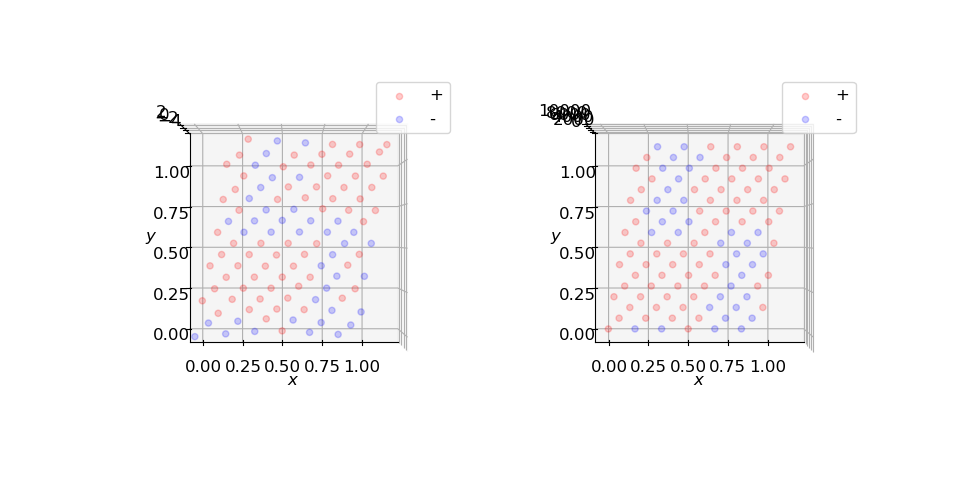

In [148]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax.set_zlim(-2, 10000)
# ax.set_zlim(9.38, 9.4)

plt.show()

plt.savefig('./TM'+str(iA)+'ss'+str(tautil1)+'.pdf',bbox_inches='tight')

In [164]:
tau

(0.20837781320031648+1.1817693036146495j)

/tmp/ipykernel_6042/3565985720.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_6042/3565985720.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_6042/3565985720.py:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_6042/3565985720.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)


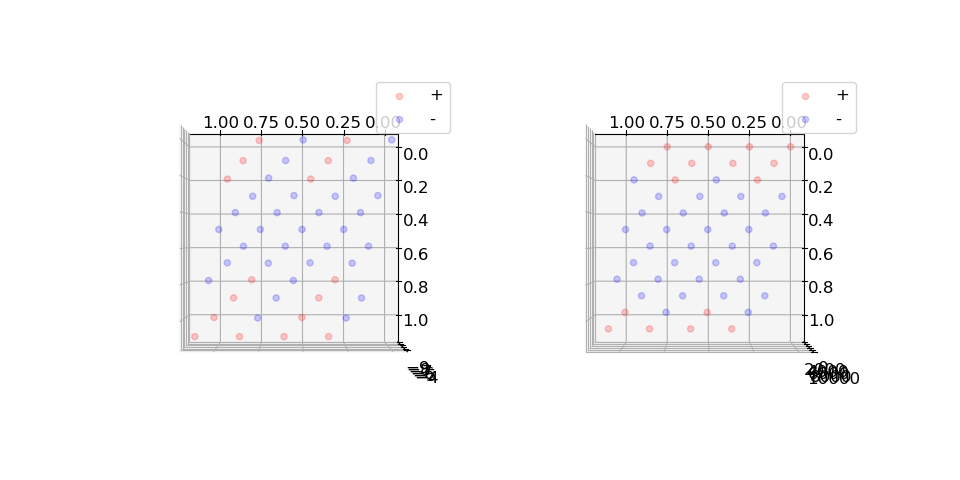

In [134]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax.set_zlim(-2, 10000)
# ax.set_zlim(9.38, 9.4)

plt.show()

# plt.savefig('./TAss.pdf',bbox_inches='tight')

In [144]:
iA = 1
angle = alphaM[iA]+tildealphaM[iA]

tmp = 2.0 * mixing( [np.real(Tss_analy.T[2]), np.imag(Tss_analy.T[2])], angle )
# tmp = 2.0 * np.real(Tss_analy.T[2])
TMss_analytic = np.array([XY.T[0], XY.T[1], tmp]).T

In [145]:
jk = Jackknife( Nbin, binsize, TBss[nskip:] )

In [146]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [XY.T[0][xx], XY.T[1][yy], 
                   jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Tss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/tmp/ipykernel_6042/3565985720.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_6042/3565985720.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_6042/3565985720.py:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_6042/3565985720.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)


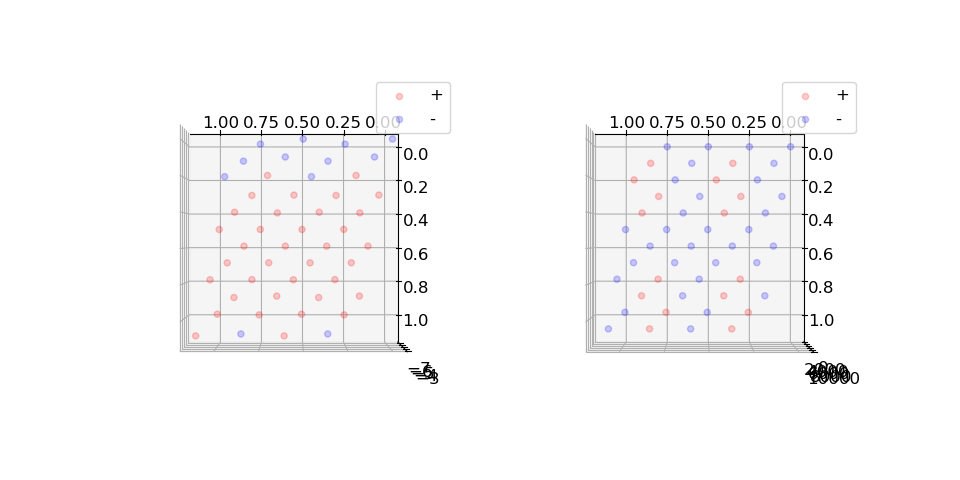

In [147]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax.set_zlim(-2, 10000)
# ax.set_zlim(9.38, 9.4)

plt.show()

# plt.savefig('./TAss.pdf',bbox_inches='tight')

In [140]:
iA = 2
angle = 3.7 # alphaM[iA]+tildealphaM[iA]

tmp = 2.0 * mixing( [np.real(Tss_analy.T[2]), np.imag(Tss_analy.T[2])], angle )
# tmp = 2.0 * np.real(Tss_analy.T[2])
TMss_analytic = np.array([XY.T[0], XY.T[1], tmp]).T

In [141]:
jk = Jackknife( Nbin, binsize, TCss[nskip:] )

In [142]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [XY.T[0][xx], XY.T[1][yy], 
                   jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Tss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/tmp/ipykernel_6042/3565985720.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_6042/3565985720.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_6042/3565985720.py:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_6042/3565985720.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)


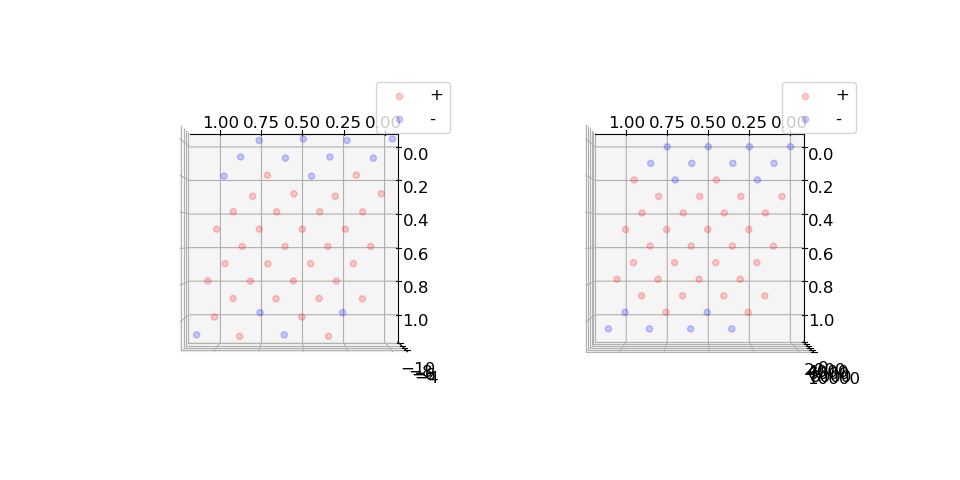

In [143]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax.set_zlim(-2, 10000)
# ax.set_zlim(9.38, 9.4)

plt.show()

# plt.savefig('./TAss.pdf',bbox_inches='tight')

In [139]:
jk = Jackknife( Nbin, binsize, np.moveaxis(Tss2, 1, 0)[nskip:] )

In [173]:
iA=2

In [174]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [XY.T[0][xx], XY.T[1][yy], 
                   jkm[iA,yy,xx], jke[iA,yy,xx] ] for xx in range(shape[2])] for yy in range(shape[1])])

tmp2 = tmp.flatten()
Tss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

In [175]:
# # plt.close()
# fig = plt.figure(figsize=plt.figaspect(0.5))

# #################

# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(elev=90., azim=90)

# ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# # ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.legend()

# # ax = fig.add_subplot(122, projection='3d')
# # ax.view_init(elev=90., azim=90)

# # ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
# # ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)
# # # ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# # ax.legend()

# ax.set_zlim(-2, 10000)
# # ax.set_zlim(9.38, 9.4)

# plt.show()

In [176]:
angle

2.0943951023931957

/scratch/273640.1.ood/ipykernel_3371928/3565985720.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/scratch/273640.1.ood/ipykernel_3371928/3565985720.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
/scratch/273640.1.ood/ipykernel_3371928/3565985720.py:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
/scratch/273640.1.ood/ipykernel_3371928/3565985720.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)


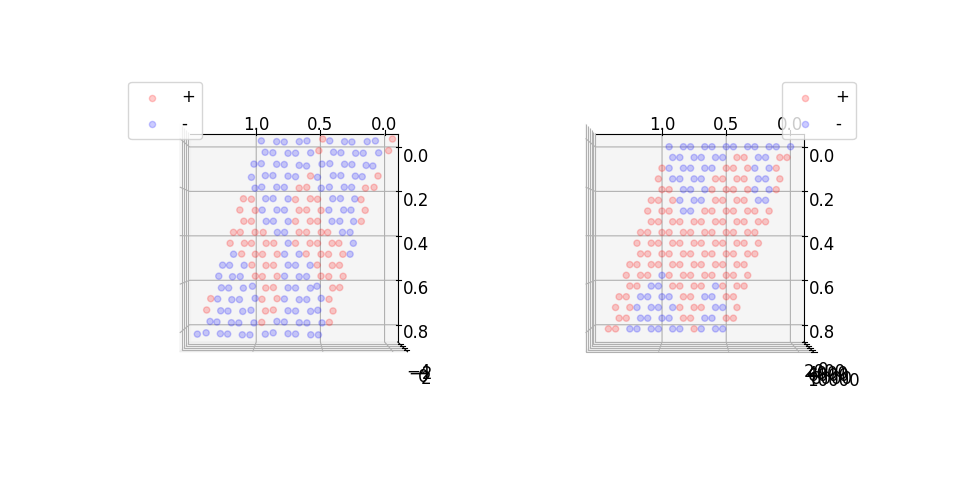

In [177]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax.set_zlim(-2, 10000)
# ax.set_zlim(9.38, 9.4)

plt.show()

# plt.savefig('./TAss.pdf',bbox_inches='tight')

In [201]:
yy = np.imag(Tss_analy.T[2])

In [202]:
Tyyss = jk.mean()[1] + jk.mean()[2]

/scratch/273640.1.ood/ipykernel_3371096/2137862128.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(Tyyss.T), c='r', marker='o', label="+", alpha=0.2)
/scratch/273640.1.ood/ipykernel_3371096/2137862128.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-Tyyss.T), c='b', marker='o', label="-", alpha=0.2)
/scratch/273640.1.ood/ipykernel_3371096/2137862128.py:19: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(yy), c='r', marker='o', label="+", alpha=0.2)
/scratch/273640.1.ood/ipykernel_3371096/2137862128.py:20: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-yy), c='b', marker='o', label="-", alpha=0.2)


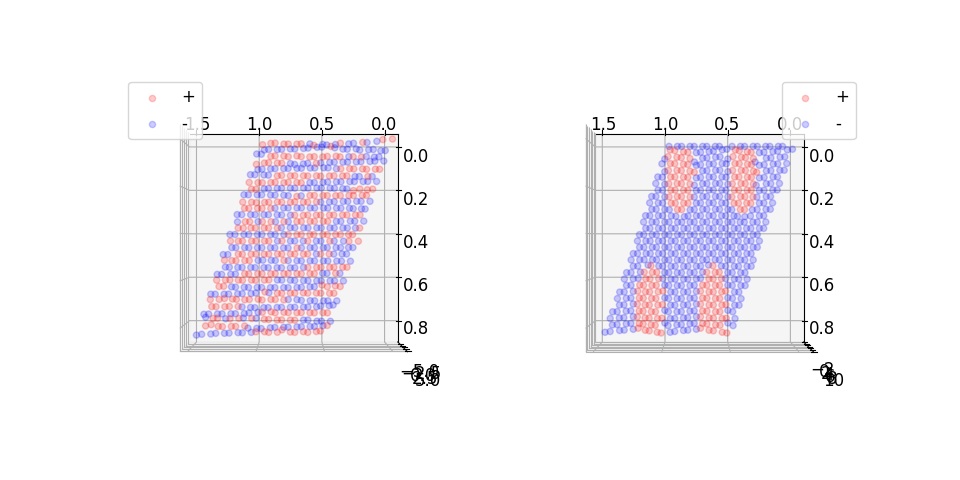

In [204]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(Tyyss.T), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-Tyyss.T), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)

# ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(yy), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-yy), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax.set_zlim(-2, 10)
# ax.set_zlim(9.38, 9.4)

plt.show()

# plt.savefig('./TAss.pdf',bbox_inches='tight')

In [ ]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(Tss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-Tss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax.set_zlim(-2, 10000)
# ax.set_zlim(9.38, 9.4)

plt.show()

# plt.savefig('./TAss.pdf',bbox_inches='tight')

In [189]:
mix_matrix = np.matrix([
    [np.cos(alphaM[0]+tildealphaM[0]), -np.sin(alphaM[0]+tildealphaM[0]), dM[0]],
    [np.cos(alphaM[1]+tildealphaM[1]), -np.sin(alphaM[1]+tildealphaM[1]), dM[1]],
    [np.cos(alphaM[2]+tildealphaM[2]), -np.sin(alphaM[2]+tildealphaM[2]), dM[2]]
])

mix_inv=np.linalg.inv( mix_matrix )

In [308]:
Txxss = mix_inv[0,0]*Tss2[0] + mix_inv[0,1]*Tss2[1] + mix_inv[0,2]*Tss2[2]

In [309]:
Txyss = mix_inv[1,0]*Tss2[0] + mix_inv[1,1]*Tss2[1] + mix_inv[1,2]*Tss2[2]

In [310]:
Const_ss = mix_inv[2,0]*Tss2[0] + mix_inv[2,1]*Tss2[1] + mix_inv[2,2]*Tss2[2]

In [320]:
jk = Jackknife( Nbin, binsize, Txyss[nskip:] )

In [321]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [XY.T[0][xx], XY.T[1][yy], 
                   jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Txxss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

In [322]:
Txxss1

array([[ 0.00000000e+00,  0.00000000e+00,  1.38176270e+01,
         4.67653331e-03],
       [ 1.75293907e-01,  0.00000000e+00, -6.63455010e-01,
         4.89093174e-03],
       [ 2.50000000e-01,  0.00000000e+00, -3.95182251e-01,
         3.86436260e-03],
       [ 4.25293907e-01,  0.00000000e+00,  7.36475157e+00,
         4.50416197e-03],
       [ 5.00000000e-01,  0.00000000e+00,  1.38176270e+01,
         4.67653331e-03],
       [ 6.75293907e-01,  0.00000000e+00, -6.63455010e-01,
         4.89093174e-03],
       [ 7.50000000e-01,  0.00000000e+00, -3.95182251e-01,
         3.86436260e-03],
       [ 9.25293907e-01,  0.00000000e+00,  7.36475157e+00,
         4.50416197e-03],
       [ 0.00000000e+00, -7.16244903e-03, -1.14100520e+00,
         4.88334345e-03],
       [ 1.75293907e-01, -7.16244903e-03, -1.42276120e+00,
         3.25295694e-03],
       [ 2.50000000e-01, -7.16244903e-03, -6.78609339e-01,
         4.98882286e-03],
       [ 4.25293907e-01, -7.16244903e-03, -7.79985472e-01,
      

In [323]:
angle = 0.0
tmp = 2.0 * np.real(Tss_analy.T[2])
# tmp = 2.0 * np.real(Tss_analy.T[2])
Txxss_analytic = np.array([XY.T[0], XY.T[1], tmp]).T

/scratch/272866.1.ood/ipykernel_2967102/1711197125.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(Txxss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/scratch/272866.1.ood/ipykernel_2967102/1711197125.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-Txxss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
/scratch/272866.1.ood/ipykernel_2967102/1711197125.py:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
/scratch/272866.1.ood/ipykernel_2967102/1711197125.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)


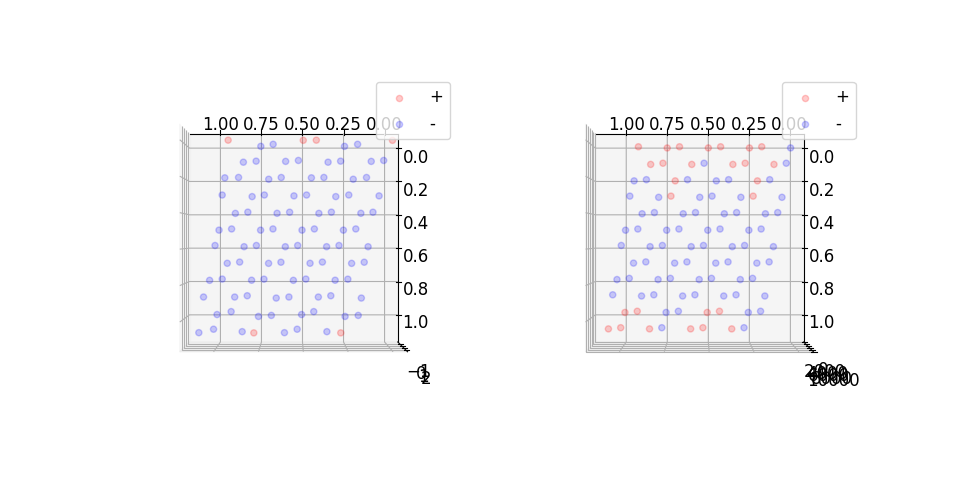

In [324]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(Txxss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-Txxss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(XY.T[0], XY.T[1], np.log(TMss_analytic.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(XY.T[0], XY.T[1], np.log(-TMss_analytic.T[2]), c='b', marker='o', label="-", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

ax.set_zlim(-2, 10000)
# ax.set_zlim(9.38, 9.4)

plt.show()

# plt.savefig('./TAss.pdf',bbox_inches='tight')

In [264]:
Const_ss

array([[[-6.76758975e+02,  2.62221563e+01,  1.36861887e+01, ...,
          2.62221563e+01,  1.36861887e+01, -4.06570475e+02],
        [-1.16086424e+02,  1.34255345e+01,  3.99720636e+01, ...,
          1.34255345e+01,  3.99720636e+01,  6.43523833e+01],
        [ 1.68986769e+01,  1.61440083e+01,  8.55035407e+01, ...,
          1.61440083e+01,  8.55035407e+01,  1.16801364e+02],
        ...,
        [ 3.37382548e+01,  1.09341161e+01,  2.22279840e+01, ...,
          1.09341161e+01,  2.22279840e+01,  3.58817895e+01],
        [ 9.68951428e+01,  1.19091307e+02,  1.85312741e+01, ...,
          1.19091307e+02,  1.85312741e+01,  2.38925986e+01],
        [-5.19168643e+00,  6.57267857e+01,  2.38164137e+00, ...,
          6.57267857e+01,  2.38164137e+00,  1.26497866e+01]],

       [[-6.61980154e+02,  2.58283744e+01,  1.82379371e+01, ...,
          2.58283744e+01,  1.82379371e+01, -4.02769164e+02],
        [-1.17435683e+02,  1.20772041e+01,  2.41496251e+01, ...,
          1.20772041e+01,  2.41496251e

In [257]:
Tss2.shape

(3, 1111, 12, 8)

In [235]:
tmp1.shape

(1100, 24, 16)

In [162]:
conneps = 0.5 * np.sum( np.array([ DBetaDmu[0]*Kss_s[0], DBetaDmu[1]*Kss_s[1], DBetaDmu[2]*Kss_s[2] ]),
                       axis=0 )

connepsS = np.array([ShiftCorr( conneps, 0, -1 ), ShiftCorr( conneps, 1, -1 ), ShiftCorr( conneps, 2, -1 )])

In [160]:
connepsS = np.array([ShiftCorr( conneps, 0, -1 ), ShiftCorr( conneps, 1, -1 ), ShiftCorr( conneps, 2, -1 )])

In [173]:
ss = np.array([np.loadtxt(directory1+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [176]:
coeff_ss = -tanhBeta-divs-np.sum( DBetaDmu*tanhBeta )+1.0-div_eps
disc = np.array([coeff_ss[0]*ss, coeff_ss[1]*ss, coeff_ss[2]*ss])

In [ ]:
Ks = np.array([ KA, KB, KC ]).transpose()
hop_part = DBetaDKappa*( Ks - tanhBeta ) - divs
eps_part = np.sum( DBetaDmu*tanhBeta ) - np.sum( DBetaDmu*Ks, axis=1 ) - 1.0 + div_eps
subt = (hop_part.T - eps_part).T
scaled = subt * 2.0*np.pi/r**2 / (TildeEll*alat)

In [ ]:
eps_part = np.sum( DBetaDmu*tanhBeta ) - np.sum( DBetaDmu*Ks_ss, axis=1 ) - 1.0 + div_eps

In [ ]:
subt = (hop_part.T - eps_part).T
scaled = subt * 2.0*np.pi/r**2 / (TildeEll*alat)

In [ ]:
ss = np.array([np.loadtxt(directory1+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])